In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


#  🩺 Pima Indians Diabetes Prediction 

In this notebook, we will analyze and model the Pima Indians Diabetes dataset using classical supervised learning techniques and ensemble models like Random Forest, AdaBoost, and Gradient Boosting.

We aim to:
- Explore the dataset and fix any data quality issues
- Train baseline and ensemble models
- Compare performance using accuracy, classification report, and ROC AUC


In [2]:
# 1. Import thư viện cần thiết
import pandas as pd
import numpy as np

# 2. Load dataset (sau khi đã add đúng dataset)
df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")

# 3. Kiểm tra tổng quát
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 📊 Exploratory Data Analysis (EDA)

We begin by exploring the dataset to understand the distribution of features, detect missing or invalid values (e.g., zeroes in medical measurements), and visualize the relationships between variables and the target label (`Outcome`).


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# Các cột không nên có giá trị 0 (vì không hợp lý về mặt y học)
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Đếm số giá trị 0 ở mỗi cột
for col in cols_with_zero:
    zero_count = (df[col] == 0).sum()
    print(f"{col}: {zero_count} giá trị 0")


Glucose: 5 giá trị 0
BloodPressure: 35 giá trị 0
SkinThickness: 227 giá trị 0
Insulin: 374 giá trị 0
BMI: 11 giá trị 0


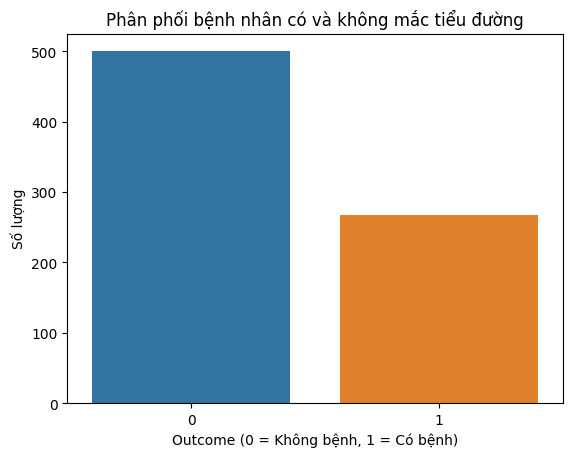

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Outcome', data=df)
plt.title("Phân phối bệnh nhân có và không mắc tiểu đường")
plt.xlabel("Outcome (0 = Không bệnh, 1 = Có bệnh)")
plt.ylabel("Số lượng")
plt.show()

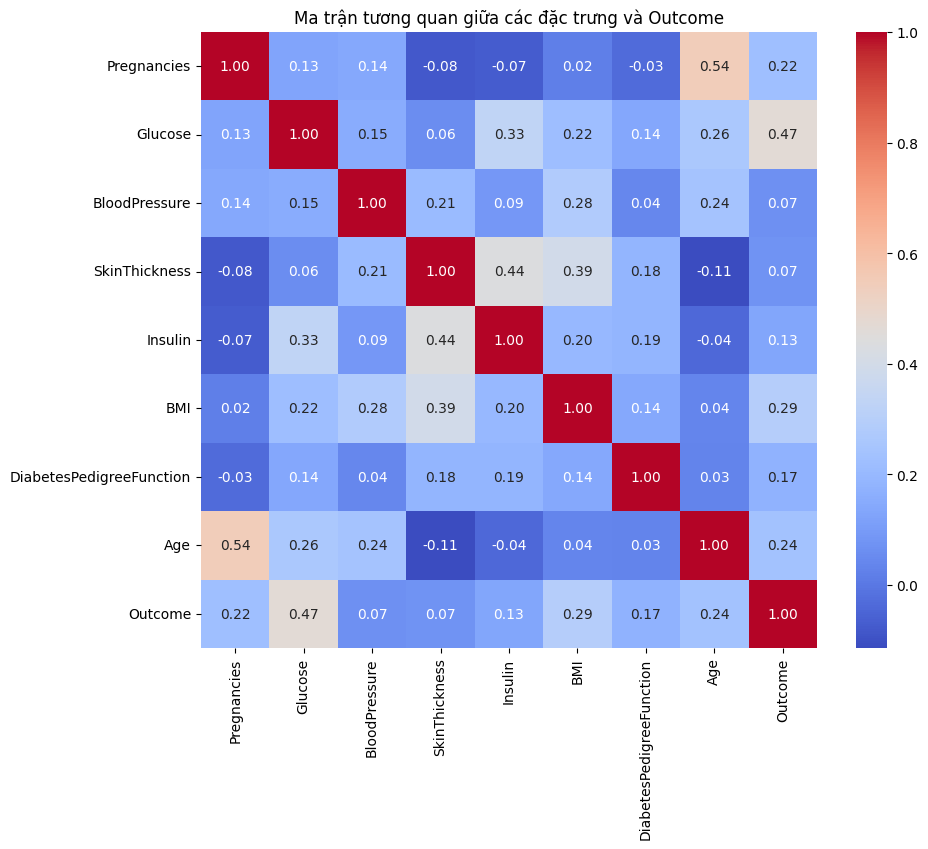

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Ma trận tương quan giữa các đặc trưng và Outcome")
plt.show()


## 🧹 Data Cleaning & Preprocessing

Before training our models, we need to clean the dataset by replacing biologically invalid zero values with more reasonable estimates (like the median). We also standardize the features to improve model convergence.


In [7]:
# Các cột không nên có giá trị 0
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Thay 0 bằng median của cột tương ứng
for col in cols_to_fix:
    median_val = df[col].median()
    df[col] = df[col].replace(0, median_val)

# Kiểm tra lại
(df[cols_to_fix] == 0).sum()


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [8]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chuyển kết quả về DataFrame (gắn lại tên cột)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.866045,-0.031990,0.831114,-0.608201,0.167240,0.468492,1.425995
1,-0.844885,-1.205066,-0.528319,0.180566,-0.608201,-0.851551,-0.365061,-0.190672
2,1.233880,2.016662,-0.693761,-0.469981,-0.608201,-1.331838,0.604397,-0.105584
3,-0.844885,-1.073567,-0.528319,-0.469981,-0.006185,-0.633239,-0.920763,-1.041549
4,-1.141852,0.504422,-2.679076,0.831114,0.695378,1.549885,5.484909,-0.020496


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)

y_train.head()

353    0
711    0
373    0
46     0
682    0
Name: Outcome, dtype: int64

## 🤖 Model Training & Evaluation

We will train both basic and ensemble models to predict diabetes. Evaluation will be done using accuracy and classification metrics on the test set.


In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

print("Logistic Regression:")
evaluate_model(lr, X_test, y_test)


Logistic Regression:
Accuracy: 0.7077922077922078

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

Confusion Matrix:
 [[82 18]
 [27 27]]


In [13]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

print("Decision Tree:")
evaluate_model(dt, X_test, y_test)


Decision Tree:
Accuracy: 0.6688311688311688

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.79      0.76       100
           1       0.53      0.44      0.48        54

    accuracy                           0.67       154
   macro avg       0.63      0.62      0.62       154
weighted avg       0.66      0.67      0.66       154

Confusion Matrix:
 [[79 21]
 [30 24]]


In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print("K-Nearest Neighbors:")
evaluate_model(knn, X_test, y_test)


K-Nearest Neighbors:
Accuracy: 0.7077922077922078

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.78       100
           1       0.60      0.52      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

Confusion Matrix:
 [[81 19]
 [26 28]]


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

print("Random Forest:")
evaluate_model(rf, X_test, y_test)


Random Forest:
Accuracy: 0.7597402597402597

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.68      0.59      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154

Confusion Matrix:
 [[85 15]
 [22 32]]


In [16]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train, y_train)

print("AdaBoost:")
evaluate_model(ab, X_test, y_test)

AdaBoost:
Accuracy: 0.7467532467532467

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       100
           1       0.65      0.59      0.62        54

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154

Confusion Matrix:
 [[83 17]
 [22 32]]


In [17]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

print("Gradient Boosting:")
evaluate_model(gb, X_test, y_test)


Gradient Boosting:
Accuracy: 0.7597402597402597

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.68      0.59      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154

Confusion Matrix:
 [[85 15]
 [22 32]]


In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

print("XGBoost:")
evaluate_model(xgb, X_test, y_test)


XGBoost:
Accuracy: 0.7727272727272727

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       100
           1       0.70      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154

Confusion Matrix:
 [[86 14]
 [21 33]]


In [19]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('gb', GradientBoostingClassifier())
    ],
    voting='soft'
)

voting.fit(X_train, y_train)

print("Voting Classifier:")
evaluate_model(voting, X_test, y_test)


Voting Classifier:
Accuracy: 0.7337662337662337

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80       100
           1       0.64      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.70       154
weighted avg       0.73      0.73      0.73       154

Confusion Matrix:
 [[83 17]
 [24 30]]
